# Just enough PyTorch to be dangerous 

In [110]:
# Useful imports and functions
import os
import time
import timeit
import numpy as np
import heapq
import random
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def tensor_information(tensor, total=False):
    """
    Print summary information about a PyTorch tensor, including type, shape, device, memory usage, and optionally detailed metadata.

    Args:
        tensor (torch.Tensor): The tensor to inspect.
        total (bool, optional): If True, print detailed information including contents, dtype, element size, buffer size, and memory address. Default is False.
    """
    num_elements = tensor.numel()
    element_size = tensor.element_size()  # in bytes
    data_buffer_size = num_elements * element_size
    
    try:
        metadata_size = sys.getsizeof(tensor)
    except:
        metadata_size = 0  # torch.Tensor doesn't always expose metadata in Python
    
    
    print("Type : ", type(tensor))
    print("Tensor shape : ", tuple(tensor.shape))
    print("Device : ", tensor.device)
    print("Approximate total size (metadata + data buffer):", metadata_size + data_buffer_size, "bytes")
    print()
    
    if total:
        print(f"Tensor :\n", tensor, "\n")
        print("Torch dtype : ", tensor.dtype)
        print("Number of elements : ", num_elements)
        print("Element size : ", element_size, "bytes")
        print("Data buffer size (nbytes) : ", data_buffer_size, "bytes")
        print("Shallow Memory Size (Python object metadata): ", metadata_size, "bytes")
        print("ID (memory address):", hex(id(tensor)))
        print()

def get_params_norm(model: nn.Module) -> float:
    """Compute the L2 norm of all parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        float: The L2 norm of all parameters.
    """
    
    assert isinstance(model, torch.nn.Module), "model must be a PyTorch nn.Module"
    
    norm = 0
    for p in model.parameters():
        norm = norm + p.norm() ** 2
    return norm.sqrt().item()

def get_grad_norm(model: nn.Module) -> float:
    """
    Compute the L2 norm of all gradients in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        float: The L2 norm of all gradients.
    """
    assert isinstance(model, torch.nn.Module), "model must be a PyTorch nn.Module"
    
    norm = 0
    for p in model.parameters():
        if p.grad is not None:
            norm = norm + p.grad.norm() ** 2
    return norm.sqrt().item()
    



Hi, I am Lorenzo Vannini an AI Engineer.

I’m lucky enough to work at a university that is both very prestigious and a genuinely exciting place to do research.

This notebook is meant to be a place where i can learn by doing and a deep dive in Pytorch is something i have always wanted to do.

This is not a complete full guide on Pytorch, I assume you have a familiarity with programming and with Deep learning in general.

This work is meant to be a *"How I wish I would have been taught when I was a student"*

    This is notebook is inspired by an interview at an italian googler ML enginner where he said that "the best way to learn is by doing".

## Chapter 1 : The basics

     What is PyTorch?
PyTorch is an open-source deep learning framework (not a library !) developed by Facebook’s AI Research lab (FAIR). 

It's widely used in academia and industry due to its:

Dynamic computation graph

Pythonic interface (feels like NumPy)

GPU acceleration

Tight integration with autograd (automatic differentiation)

---

     What Is a Tensor?
A tensor in PyTorch is:

A multidimensional array.

Device flexibility (CPU, GPU)

Optional gradient tracking (for backpropagation)

Efficient memory sharing and computation using low-level C/C++ backend

    I am sure many of you know what is a tensor but *why do we need a tensor in the first place?*. 

    I mean why not just work with numpy or pyhton lists?

    Why bothering GPUs ? ( the same question can be transformed in *why NVIDIA has a market capitalization of 128 trilions dollar?*)
---

Python Lists:

*Python is great* since it is a very flexible programming language, but it is not particularly efficient.

In Python everthing is an object, unlike C or C ++ you do not declare varibale by using int x = 5 or float x = 5.5. You just declare and the variable will have its own attrubte and methods, *like an object*.

By writing x = 5, pyhton creates and integer object, this object holds the value 5 and you can call many methods , like type(x) and so on.

This design is very different from languages like C. In C, a variable is essentially a label for a specific memory location. Declaring int x = 5; tells the compiler to reserve a fixed chunk of memory to store the integer value directly. Accessing or modifying x involves simple, low-level operations on that memory.

Python lists, however, are not contiguous blocks of raw data. Instead, they are collections of pointers to objects stored elsewhere in memory. Each element of a list is a full Python object with its own metadata. As a result, when you perform arithmetic with list elements, the CPU must repeatedly follow pointers scattered across memory, load the corresponding objects, and then handle their dynamic type information. Thus, Operations are incredibly slow because the CPU has to jump around in memory to fetch each element and perform the calculation one by one. Python lists force the CPU to follow pointers all over the memory.

Moreover, Pthon lists are one dimensional, despite the possibility of creatinga list of list a tensor-like representation is far more convenient

Example :

    list: [1, 2, 3]
    memory: |ptr1|ptr2|ptr3| --> values stored somewhere else in memory
    
---

Think about it, just to sum two simple lists (a + b) python has to :
- Follows the pointer for a[i] and b[i] to get the object
- checks type
- call the correct addition function
- create a new object


Key takeaway:

    A C-like array is a contiguous block of memory where all elements have the same size, so operations are fast. A Python list, on the other hand, is a contiguous block of memory that holds pointers to Python objects, operations with list are slow.


*Ok, so lists are slow but why tensor?*

A Tensor has many advantages: 
- Homogeneous type --> All elements are stored in the same data type. No need to type checks per element.
- Contiguous memory --> Stored as a single block.
- Compiled kernels --> The actual math is done in optimized C/C++ code
- Multidimensional --> They are the best way to represent data in almost every possible situation

In [3]:
# Example
a = torch.tensor( [[1.0, 2.0], [3.0, 128.0]] )
tensor_information ( a , total=True)

Type :  <class 'torch.Tensor'>
Tensor shape :  (2, 2)
Device :  cpu
Approximate total size (metadata + data buffer): 88 bytes

Tensor :
 tensor([[  1.,   2.],
        [  3., 128.]]) 

Torch dtype :  torch.float32
Number of elements :  4
Element size :  4 bytes
Data buffer size (nbytes) :  16 bytes
Shallow Memory Size (Python object metadata):  72 bytes
ID (memory address): 0x22e36628180



*Why a torch.float32 ?*

    32 bit floating point number offers a decent precision while consuming a lot less memory than a flot64.

*So let'say we have an n dimensional tensor called a, but where does a live?*

a is a Python object — an instance of the Python class torch.Tensor.

But the actual data and core logic live in a C++ program underneath.

**The Python object acts like a handle, or interface, that lets you interact with the C++ code easily**

**A Python object torch.Tensor contains a pointer to this C++ object**

a = torch.tensor(...)   -->   PyTorch Python object torch.Tensor

                                points to C++ at::TensorImpl instance

                                ├─ raw memory buffer (float* or int*)

                                ├─ tensor metadata (shape, strides, dtype)

                                ├─ device info (CPU, GPU)

                                └─ autograd info (grad_fn, version counter)

The Python object acts like a remote control for the C++ object doing the real work.

In [86]:
# True, default tensor is contiguous
a.is_contiguous()

True

Using a PyTorch tensor does not mean you “skip bytecode.” Python bytecode is still there, but most of the heavy work is delegated to optimized C++ code. That’s why PyTorch feels like Python, but runs at speeds close to low-level code.

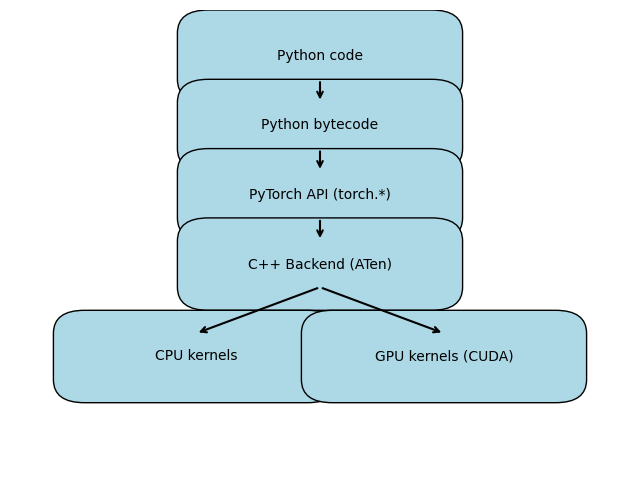

**data of any kind (images,scalars,time series...) can be written as a n dimensional tensor**

---

*Now let's answer the 4 trilion dollars question : *why NVIDIA has a market capitalization of 4 trilions dollar?**

Here is a beautiful chart by statista : https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.statista.com%2Fchart%2F34787%2Fnvidia-market-cap-in-comparison-to-major-companies%2F&psig=AOvVaw2LcJPDAD70CQLVnMdXl2Bn&ust=1757092011404000&source=images&cd=vfe&opi=89978449&ved=0CBgQjhxqFwoTCMi5ovvLv48DFQAAAAAdAAAAABA2

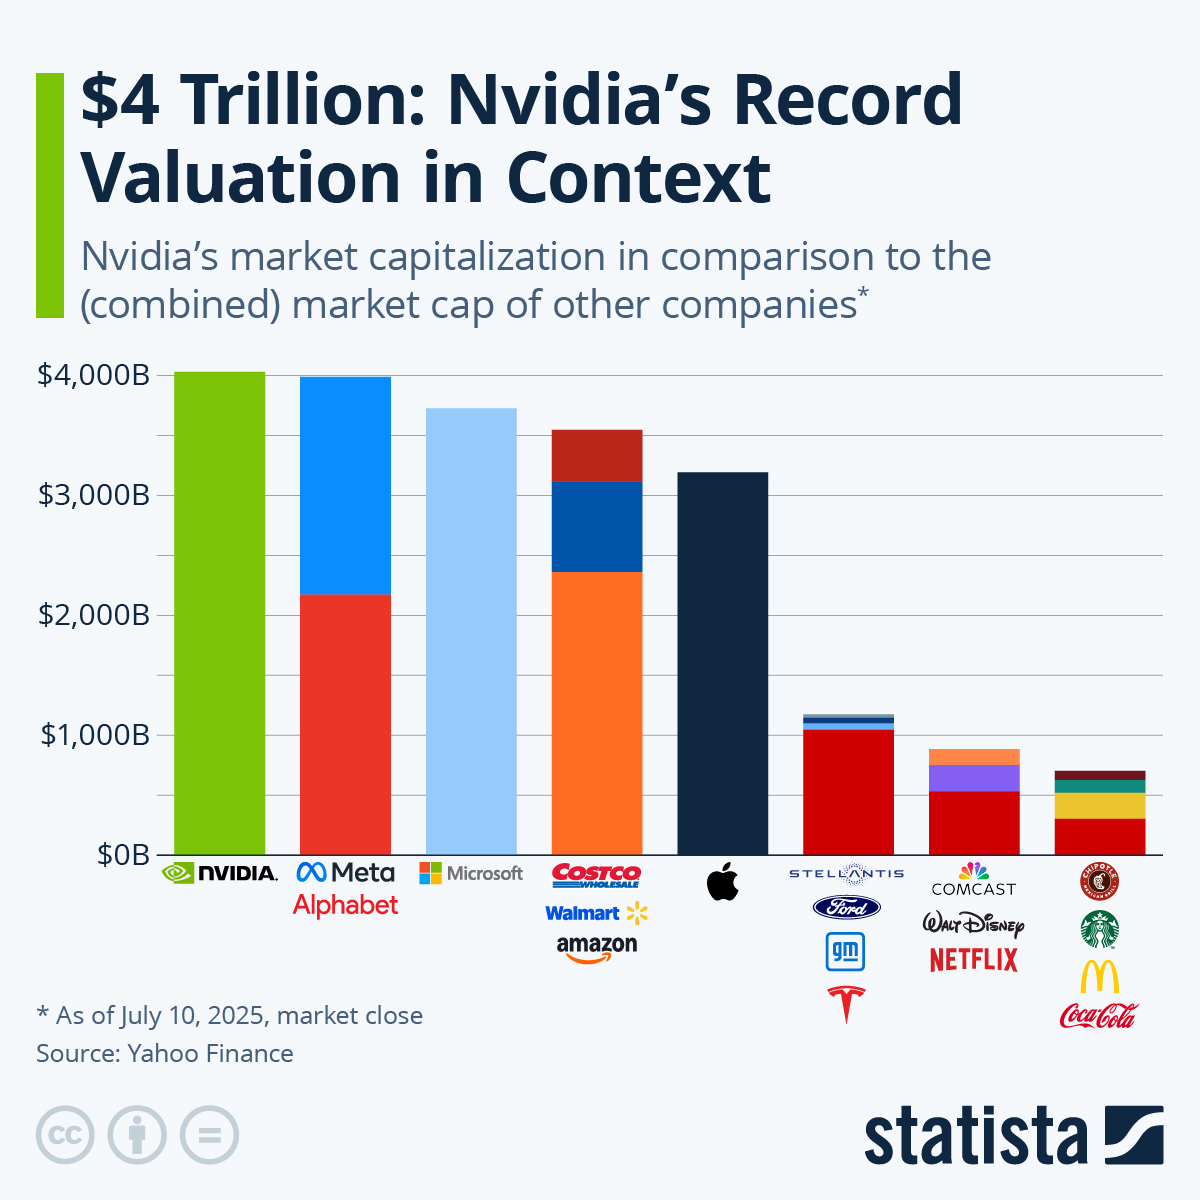

To really grasp why GPUs have become so incredibily popular we need to take a step back 

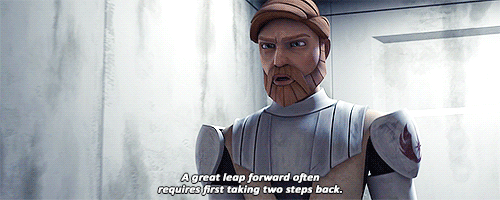

Side Note : By no means I am an expert in CPU/GPU/CUDA. Many people, incredibly more talented and smarter than me, have written about these topics and understand their mechanism way better than I do. Take this words with a grain of salt.


CPUs is essentially the "brain" of your PC. Even though CPUs are called "processors" they are a combination of many complicated components that work together.

One of the key factors in understanding CPU performance is the concept of cores. A core is an independent processing unit within the CPU. Although each core can handle one instruction at a time, having multiple cores allows a CPU to process several tasks simultaneously. This is why modern CPUs are multicore: they enable multitasking and allow programs that can split work across threads to run faster

By the way the Global Interpreter Lock, or GIL, is a mechanism in CPython, the standard Python interpreter, that ensures only one thread executes Python bytecode at a time. Its primary purpose is to make memory management safe. Python uses reference counting for garbage collection, and without the GIL, multiple threads could simultaneously modify reference counts, potentially causing memory corruption or crashes.

Because of the GIL, even if a computer has multiple CPU cores, Python threads cannot fully utilize them. In the context of numerical computing and deep learning, this limitation is one reason why libraries like NumPy and PyTorch offload heavy computations to compiled C or GPU kernels, they can separate processes with their own Python interpreter and memory space. Each process has its own GIL, allowing multiple CPU cores to be utilized simultaneously.

Another critical piece in CPUs is the cache, a small but extremely fast memory built directly into the CPU. The cache stores instructions and data that the CPU is likely to use soon, making access much faster than retrieving data from RAM. The speed and size of the cache matter a lot because they directly impact how quickly the CPU can fetch instructions and reduce idle waiting time. Implementing some memory in a faster format can lead to large performance improvements. When trying to read from or write to a location in the memory, the processor checks whether the data from that location is already in the cache. If so, the processor will read from or write to the cache instead of the much slower main memory. Then there’s the clock speed, measured in gigahertz, which represents how many cycles a CPU can perform per second. Higher clock speeds mean each core can process instructions faster, but this isn’t the whole story. The architecture of the CPU, how the cores are designed, how they communicate with cache and RAM, and how efficiently each clock cycle is used, all play a huge role.

    Fact : CPUs process data sequentially

*Ok so what?*

    PyTorch can run entirely on CPU but is limited because it only has a few powerful cores. That’s where the GPU comes in, with thousands of cores designed for massive parallelism.

*Fine. Why GPU then?*

A GPU, or Graphics Processing Unit, was originally built for one task: drawing images on your screen by performing millions of very similar mathematical operations in parallel. Instead of a few powerful cores like a CPU, a GPU contains thousands of smaller, simpler cores.

If you need to process large amounts of data in a parallelized fashion, GPUs are the ideal solution. They excel at performing many simple and repetitive calculations efficiently.

    Imagine you need to multiply a million pairs of numbers. A CPU will take a few at a time and go through them sequentially, while a GPU will distribute the million pairs across thousands of cores and compute them all almost simultaneously.

GPUs organize their cores into groups called streaming multiprocessors. These multiprocessors can share a small but extremely fast cache of memory among themselves, allowing computations to be reused quickly without constantly going back to the slower global GPU memory. The tradeoff is that GPUs are not very good at tasks with lots of branching logic, like “if this, do that, otherwise do something else.” They are built for massive numbers of identical operations on large arrays of data.

Matrix operations form the computational backbone of modern GPU workloads, particularly in domains like linear algebra, convolutional neural networks, and finite element analysis. GPUs are architected to exploit the regularity and parallelism of matrix operations. For example, matrix-matrix multiplication (GEMM) maps naturally to GPU thread blocks, where each block computes a submatrix in parallel

source : https://blogs.nvidia.com/blog/whats-the-difference-between-a-cpu-and-a-gpu/

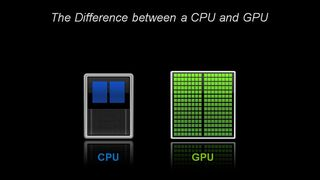

---

*Why do we need a lot of operations?*

    Because of deep learning

I will not deep dive into neural network and their complicated mechanism here but let's use a very simple NN.

Let $x = [x_1, x_2, \dots, x_n]^T$ be the input vector, for example pixels in an simple image.

Let $W^{(1)}$ be the weight matrix for the first layer, with dimensions $m \times n$.

Let $b^{(1)}$ be the bias vector for the first layer, with dimensions $m \times 1$.

The pre-activation of the first layer, $z^{(1)}$, is:
$$z^{(1)} = W^{(1)}x + b^{(1)}$$

As you can see here 

Each element is:
$$z_j^{(1)} = \sum_{i=1}^n W_{ji}^{(1)}x_i + b_j^{(1)}$$

The output of the hidden layer, $a^{(1)}$, is given by applying a non-linear activation function, $\sigma$:
$$a^{(1)} = \sigma(z^{(1)})$$

For an output layer with weight matrix $W^{(2)}$ and bias vector $b^{(2)}$, the final prediction $y_{pred}$ is:
$$y_{pred} = a^{(2)} = \sigma(W^{(2)}a^{(1)} + b^{(2)})$$

imagine what happens if $x \in \mathbb{R}^d$ and $ d = 1000, n = 10^3, m = 10^2 $, then imagine to do these moltiplication for many layers and with many more neurons... *ONLY* in the forward pass and don't let me start in the backpropagation pass.

    CPUs are optimized for sequential tasks and complex branching, not for applying the same simple operation millions of times. GPUs, on the other hand, can execute these matrix multiplications in parallel, because multiplying large matrices is essentially the same operation repeated across many elements. That’s why deep learning maps so naturally onto GPUs.

*Ok but why NVIDIA?*

---

    CUDA

source : https://blogs.nvidia.com/blog/what-is-cuda-2/

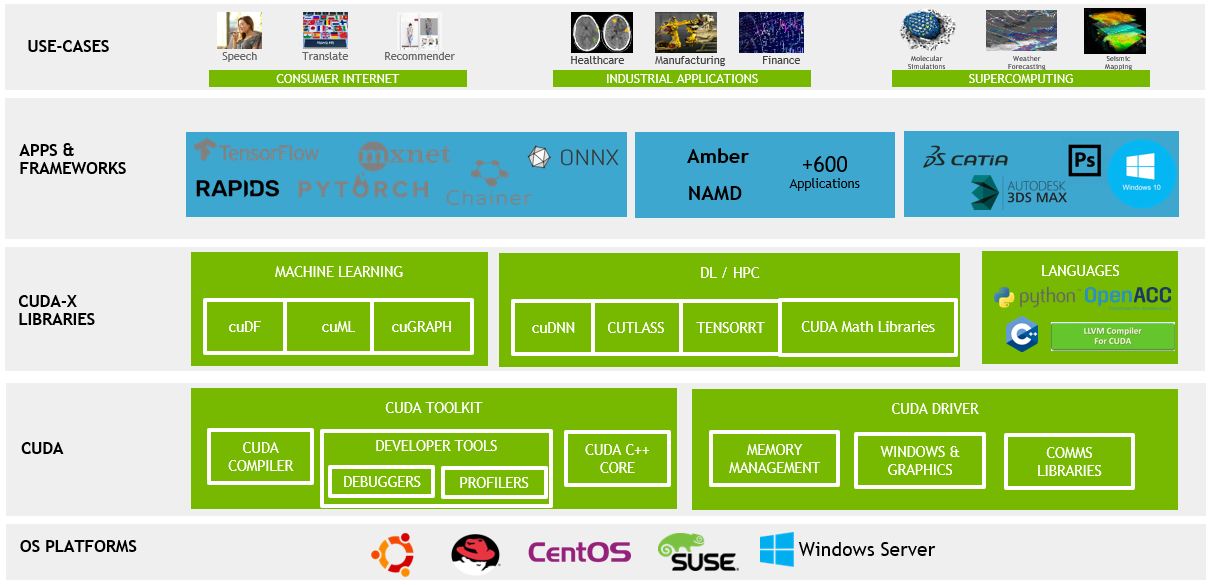

CUDA (Compute Unified Device Architecture) is NVIDIA’s parallel computing platform and programming model. It lets you write code that runs directly on the thousands of small processing cores inside a GPU.

    Think of it like this: without CUDA, the GPU is just a black box for graphics. With CUDA, it becomes a general-purpose parallel processor you can program for tasks like deep learning, physics simulations, or matrix operations

At its core, the CUDA programming model is heterogeneous. This means it assumes two different kinds of processors working together:

*The Host*: This is your CPU, the central brain of the system. The host is responsible for managing the overall program flow, setting up data, launching GPU computations, and retrieving the results. It handles the sequential, non-parallelizable parts of the application.

*The Device*: This is your NVIDIA GPU. The device is a co-processor that handles the highly parallelizable, data-intensive parts of the application.

This dual-processor model is crucial. A typical CUDA program follows a simple, yet fundamental, workflow:

The host (CPU) allocates memory on the device (GPU).

The host copies the necessary input data from its own memory (system RAM) to the device's memory (VRAM).

The host launches a kernel, a special function that runs on the GPU.

The thousands of GPU cores execute the kernel in parallel.

The host copies the results back from the device's VRAM to its own system RAM.

The most critical parts of this process are the kernel launch and the data transfer. The goal is to move the data once, perform as many parallel computations as possible on the GPU, and then move the results back only when absolutely necessary, minimizing the bottleneck of data transfer.

For deep learning, this model is almost a perfect fit. Training a neural network is essentially repeated applications of linear algebra: multiplying giant matrices, summing vectors, and applying simple elementwise functions like ReLU or sigmoid. CUDA gives PyTorch and other frameworks the ability to express these operations to the GPU. In practice, PyTorch does not generate raw CUDA kernels for every operation, instead it calls into highly tuned NVIDIA libraries like cuBLAS for matrix multiplications and cuDNN for convolutions and activation layers. These libraries know how to schedule work across blocks and how to reuse shared memory effectively, and how to keep the GPU’s compute units busy without wasting cycles.

    Moreover,

    The long-standing investment in CUDA has created a powerful ecosystem. There's a vast amount of documentation, tutorials, and a huge community of developers. This has created a self-reinforcing cycle where more people use CUDA, which leads to more libraries and tools being built for CUDA, which in turn attracts even more users. This network effect has made it incredibly difficult for competitors to catch up.

*Just try to appreciate the incredible amount of work that has been done such that normal people like us can performe very costly computations in seconds.* 

    As Stephen Jones ( one of the architects of CUDA ) said in an interview at Computerphile : " Our job at NVIDIA is to write milions lines of code so that the user just need to write one "

*ok. So this is why we use CUDA but what happens when you move something to cuda?*

    a = a.to("cuda")


When you do this in PyTorch, the tensor is copied from the host memory (the RAM managed by your CPU) into the device memory (the VRAM on your GPU).
Once the tensor lives in the VRAM, PyTorch stops scheduling its operations as CPU instructions. Instead, each tensor operation is turned into a call to a CUDA *kernel*. The kernel is a precompiled function, often from libraries like cuBLAS or cuDNN, that runs directly on the GPU cores. PyTorch doesn’t actually write CUDA code for you each time; it just dispatches to the right NVIDIA-optimized function, which knows how to use threads, blocks, shared memory, and the GPU’s architecture to run efficiently.

---

## Chapter 2 : Let's play with tensors

source : https://en.wikipedia.org/wiki/Tensor

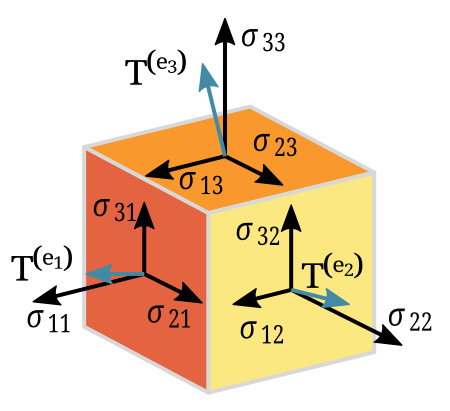

### Basics operations

In [4]:
a = torch.tensor( [ [10,20,30], [0,0,1], [11,22,33] ] )
print(a, "\n")

b = torch.tensor ( [ [1,2,3], [4,5,6] , [7,8,9] ] ) 
print(b, "\n")


tensor_information(a)
tensor_information(b)

tensor([[10, 20, 30],
        [ 0,  0,  1],
        [11, 22, 33]]) 

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) 

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 3)
Device :  cpu
Approximate total size (metadata + data buffer): 144 bytes

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 3)
Device :  cpu
Approximate total size (metadata + data buffer): 144 bytes



a * b is element by element multiplication

In [5]:
# elementwise multiplication
print(a*b)

tensor([[ 10,  40,  90],
        [  0,   0,   6],
        [ 77, 176, 297]])


torch.matmul(a, b) is matrix multiplication

In [6]:
print(torch.matmul(a,b))

tensor([[300, 360, 420],
        [  7,   8,   9],
        [330, 396, 462]])


In [7]:
# summation 
print(a + b, "\n")
tensor_information(a+b)

tensor([[11, 22, 33],
        [ 4,  5,  7],
        [18, 30, 42]]) 

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 3)
Device :  cpu
Approximate total size (metadata + data buffer): 144 bytes



In [8]:
# division
print(a / (a+b) )

tensor([[0.9091, 0.9091, 0.9091],
        [0.0000, 0.0000, 0.1429],
        [0.6111, 0.7333, 0.7857]])


In [9]:
# power elevation
d = a ** 2
d

tensor([[ 100,  400,  900],
        [   0,    0,    1],
        [ 121,  484, 1089]])

In [10]:
# A^T A
print ( torch.matmul(a.T, a))

tensor([[ 221,  442,  663],
        [ 442,  884, 1326],
        [ 663, 1326, 1990]])


In [11]:
# internal summation
M = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]])

print(M)
print(M.sum())          # sum of all elements
print(M.sum(dim=0))     # sum along rows (result: column sums)
print(M.sum(dim=1))     # sum along columns (result: row sums)

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor(21.)
tensor([5., 7., 9.])
tensor([ 6., 15.])


In [12]:
b = torch.tensor ( [ [1,2,3], [4,5,6] , [7,8,9]] ) 
a = torch.tensor([[10,20,30]])

print(b.T, " \n")
print(b, "\n")


tensor([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])  

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]) 



    unsqueeze
this is extremely handy when you need to align tensors for broadcasting or when a library function expects a specific number of dimensions. Importantly, unsqueeze does not change the underlying data; it only changes the shape of the tensor.

In [13]:
# unsqueeze

x = torch.tensor( [1,2,3] )
tensor_information(x)

Type :  <class 'torch.Tensor'>
Tensor shape :  (3,)
Device :  cpu
Approximate total size (metadata + data buffer): 96 bytes



In [14]:
# row vector
x_unsq_1 = x.unsqueeze(0)
tensor_information(x_unsq_1)

Type :  <class 'torch.Tensor'>
Tensor shape :  (1, 3)
Device :  cpu
Approximate total size (metadata + data buffer): 96 bytes



In [15]:
# column vector
x_unsq_2 = x.unsqueeze(1)
tensor_information(x_unsq_2)

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 96 bytes



In [16]:
# oopsie
x_unsq_3 = x.unsqueeze(2)
tensor_information(x_unsq_3)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

    squeeze

squeeze is essentially the opposite of unsqueeze. While unsqueeze adds a dimension of size 1, squeeze removes any dimension that has size 1.

In [ ]:
x = torch.randn(3,1,4)
tensor_information(x)

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 1, 4)
Device :  cpu
Approximate total size (metadata + data buffer): 120 bytes



In [ ]:
x_sq = x.squeeze(1)
tensor_information(x_sq)

Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 4)
Device :  cpu
Approximate total size (metadata + data buffer): 120 bytes



### Broadcasting

    You just can't sum or multiply things randomly without following the broadcatsing rule

Broadcasting is a set of rules that allows PyTorch to perform elementwise operations on tensors of different shapes without writing loops. Instead of manually expanding dimensions, PyTorch automatically “stretches” tensors to make the shapes compatible. No data is copied; it’s just a virtual expansion for computation.

To understand how this works, let's formalize the process for two tensors, $A$ and $B$, with shapes $S_A=(d_m,\dots,d_1)$ and $S_B=(e_k,\dots,e_1)$ respectively. 

**The algorithm proceeds as follows:**

**If the number of dimensions of $A$ and $B$ are not equal, augment dimensions of size $1$ to the tensor with fewer dimensions until their ranks are the same.**

This is just a conceptual step; it doesn't actually change the data. For example, if $A$ has shape $(5,3)$ and $B$ is a vector with shape $(3)$, $B$ is conceptually treated as having shape $(1,3)$ for comparison.

**Start at the last dimension (index 1) and move leftward. For each corresponding pair of dimensions, $d_i$ from $A$ and $e_i$ from $B$, check for compatibility based on the three rules above.**

$$
\text{Dimensions } d_i \text{ and } e_i \text{ are compatible if:}
\begin{cases}
d_i = e_i & \text{(They are equal)} \\
d_i = 1 & \text{(Dimension in } A \text{ is a singleton)} \\
e_i = 1 & \text{(Dimension in } B \text{ is a singleton)}
\end{cases}
$$

    If a pair of dimensions is not compatible, the tensors are not broadcastable, and the operation will fail.

**If the tensors are broadcastable, the shape of the resulting tensor $C$ will be the element-wise maximum of the two padded shapes.**
$$
S_C = (\max(d_m, e_m), \dots, \max(d_1, e_1))
$$


Suppose:

$$
A =
\begin{bmatrix}
a_{11} \\
a_{21} \\
a_{31}
\end{bmatrix} \in \mathbb{R}^{3 \times 1}, 
\quad 
B =
\begin{bmatrix}
b_1 & b_2 & b_3 & b_4
\end{bmatrix} \in \mathbb{R}^{1 \times 4}.
$$

Using broadcasting, $A$ is stretched along columns and $B$ is stretched along rows. The resulting tensor $C = A + B$ has shape $(3, 4)$:

$$
C =
\begin{bmatrix}
a_{11} + b_1 & a_{11} + b_2 & a_{11} + b_3 & a_{11} + b_4 \\
a_{21} + b_1 & a_{21} + b_2 & a_{21} + b_3 & a_{21} + b_4 \\
a_{31} + b_1 & a_{31} + b_2 & a_{31} + b_3 & a_{31} + b_4
\end{bmatrix}
$$

**If the number of dimensions of $A$ and $B$ are not equal, augment dimensions of size $1$ to the tensor with fewer dimensions until their ranks are the same : example**

Mathematically, suppose you have two tensors $A$ and $B$ with shapes:
$$
A \in \mathbb{R}^{m \times n}, \quad B \in \mathbb{R}^{1 \times n}
$$

more in detail :

$$
A=
\begin{pmatrix}
a_{11} & a_{12} & \dots & a_{1n} \\
a_{21} & a_{22} & \dots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{m1} & a_{m2} & \dots & a_{mn}
\end{pmatrix}
$$

Tensor B is a row vector:
$$
B=
\begin{pmatrix}
b_{1} & b_{2} & \dots & b_{n}
\end{pmatrix}
$$

The broadcasting process conceptually transforms $B$ into a matrix $B'$ with the shape $(m,n)$ where every row is identical to the single row of $B$.

$$
B'=
\begin{pmatrix}
b_{1} & b_{2} & \dots & b_{n} \\
b_{1} & b_{2} & \dots & b_{n} \\
\vdots & \vdots & \ddots & \vdots \\
b_{1} & b_{2} & \dots & b_{n}
\end{pmatrix}
$$

Now, the addition $C=A+B'$ is a standard element-wise operation since both tensors have the same shape.

$$
C=
\begin{pmatrix}
a_{11}+b_{1} & a_{12}+b_{2} & \dots & a_{1n}+b_{n} \\
a_{21}+b_{1} & a_{22}+b_{2} & \dots & a_{2n}+b_{n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{m1}+b_{1} & a_{m2}+b_{2} & \dots & a_{mn}+b_{n}
\end{pmatrix}
$$

When you do $C=A+B$, PyTorch sees that the last dimension of $A$ and $B$ is the same ($n$), and the second-to-last dimension is $1$ in $B$ and $m$ in $A$. According to the broadcasting rules, the size-$1$ dimension in $B$ can be stretched to match $m$. The resulting tensor $C$ has shape $(m, n)$ and each row of $B$ is added to the corresponding row of $A$.


In [ ]:
# Define A with shape (3, 1)
A = torch.tensor([[1],
              [2],
              [3]])

# Define B with shape (1, 4)
B = torch.tensor([[10, 20, 30, 40]])

# Broadcasted addition
C = A + B

print("A:\n", A)
print("B:\n", B)
print("C = A + B:\n", C)

A:
 tensor([[1],
        [2],
        [3]])
B:
 tensor([[10, 20, 30, 40]])
C = A + B:
 tensor([[11, 21, 31, 41],
        [12, 22, 32, 42],
        [13, 23, 33, 43]])


In [ ]:
A = torch.tensor( [[1,1,1,4],[10,20,30,222]] )
B = torch.tensor( [ [20],[30],[100] ])

print (A)
tensor_information(A)

print (B)
tensor_information(B)

print(A + B)

tensor([[  1,   1,   1,   4],
        [ 10,  20,  30, 222]])
Type :  <class 'torch.Tensor'>
Tensor shape :  (2, 4)
Device :  cpu
Approximate total size (metadata + data buffer): 136 bytes

tensor([[ 20],
        [ 30],
        [100]])
Type :  <class 'torch.Tensor'>
Tensor shape :  (3, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 96 bytes



RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

### Concatenate

You can concatenate tensors

    torch.cat(tensors, dim=0) where dim is the dimension along to concatenate

**All tensors must have the same shape in all dimensions except dim**

In [81]:
a = torch.arange(6).reshape(2, 3)
print(a, "\n")

b = torch.arange(6,18).reshape(4, 3)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5]]) 

tensor([[ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])


In [82]:
c = torch.cat([a,b], dim=0)
tensor_information(c)
c

Type :  <class 'torch.Tensor'>
Tensor shape :  (6, 3)
Device :  cpu
Approximate total size (metadata + data buffer): 216 bytes



tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

In [78]:
# oopsie 
c = torch.cat([a,b], dim=1)
tensor_information(c)
c

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 4 for tensor number 1 in the list.

## Chapter 3: Autograd

First thing first : if you are here, I hope you know what a gradient is and why is it useful in AI. If not, well I am sure you'll know how to learn it :). 

Just for the beauty of it here's the notation for gradient with respect to parameters $\theta$ of a function $\mathcal{L}$ ( the loss function)

$$ \nabla_{\boldsymbol{\theta}} { \mathcal{L} }$$


    Autograd is PyTorch’s automatic differentiation engine and It is a very complicated machinery. 
It computes derivatives of tensors automatically and efficiently and  builds a dynamic graph on the fly during execution.




*Why do we need a dynamic graph?*

*Now that i think about it, why do i need a graph in the first place?*

    A Feed-forward NN , at its core, is just a function, it may be a complicated one but is a function , it is a model.

Formally, we can think of a neural network as a mapping between a variable $x$ to a variable $y$.

$$
f_\theta : \mathbb{R}^n \to \mathbb{R}^m
$$

where $ f_\theta $ is parameterized by weights and biases $ \theta $.  
During training, the goal is to adjust $ \theta $ so that $ f_\theta(x) $ is a good approximation of some unknown target function $ g(x) $.


The **universal approximation theorem** tells us that:

For any continuous function

$$
g : \mathbb{R}^n \to \mathbb{R}
$$

defined on a compact set $K  \subseteq \mathbb{R}^n $, and for any $ \varepsilon > 0 $, there exists a feedforward neural network with a single hidden layer and a finite number of neurons such that the neural network function $ f_\theta $ satisfies

$$
\sup_{x \in K} \; \big| f_\theta(x) - g(x) \big| < \varepsilon
$$

---

    This result means that, given enough neurons, even a shallow neural network can approximate *any* continuous function to arbitrary precision.  
Of course, the theorem does not tell us how many neurons are required, how to train them efficiently, or how large $ \theta $ must be in practice. That is where deeper architectures and optimization methods become important.

*So that's why we use a NN, cool*

*Again, why do I need a graph?*

    a computational graph is a way of representing a mathematical function, in our case a NN, where nodes represent operations and edges carry values from one node to another.

As you know **backpropagation** is the main algorithm used to calculate the gradient of the loss function, it relies on classic formula known as the **chain rule**

Formally, given a composite function \( f(g(x)) \), we can calculate its derivative as:

$$
\frac{\partial}{\partial x} f(g(x)) = f'(g(x)) \cdot g'(x)
$$

as you can see, the derivative of a complicated function is the product of very simple derivatives

Example:

$$
f(x, y) = w = \log(x \cdot y)
$$

The computational graph for this function shows how the inputs $x$ and $y$ (on the left) flow through a series of operations to generate the output $z$.

By calling $v = x * y$ the graph can be seen as 


source : https://pytorch.org/blog/overview-of-pytorch-autograd-engine/?ajs_aid=b07df42a-41f5-40ac-bdd8-be2fa7ae618e

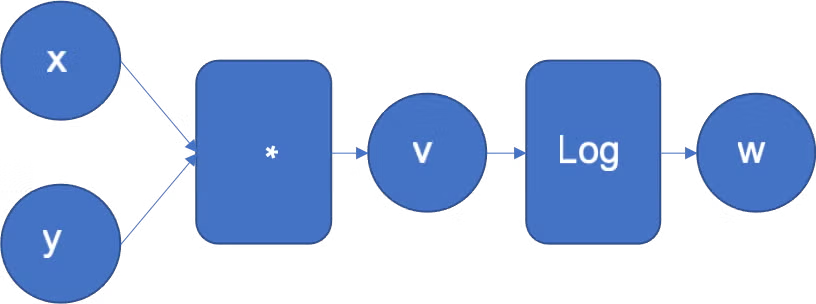

Let' say you want to calculate $\frac{\partial w}{\partial x}$ or $\frac{\partial w}{\partial y}$

$$
\frac{\partial w}{\partial x} = \frac{\partial log(v)}{\partial v}\cdot{ \frac{\partial v}{\partial x}} = \frac{1}{x \cdot y} \cdot y

$$

$$
\frac{\partial w}{\partial y} = \frac{\partial log(v)}{\partial v}\cdot{ \frac{\partial v}{\partial y}} = \frac{1}{x \cdot y} \cdot x

$$

Now, by keeping track of the function (nodes) that maps input with output, by knowing its derivative we can then use the chain rule to update the gradient.

This is extremely convenient in Deep Learning when we want to optimize our model with gradient descent.

By seeing a nested function as a computational graph, not only we can understand better backprop, we can practically build a graph, a Directed Acyclic Graph, that tracks all the operations in our code.



    Key takeaway : think of autograd as a system that builds a mathematical graph of your computations, stores derivatives at each step, and uses the chain rule to compute gradients efficiently.

    Leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

### Example: $\gamma = sin(x^2)$

When you set **requires_grad=True**, PyTorch begins tracking all operations involving that tensor. 

A tensor having requires_grad=True does not mean it has a gradient immediately.

In [ ]:
x = torch.tensor ( 10.0 , requires_grad = True )

y = x ** 2 

gamma = torch.sin(y)

In [ ]:
print(x)

tensor(10., requires_grad=True)


Because no backward has been computed yet, x.grad is None. 

A gradient is not an intrinsic property of the value; it is computed relative to some scalar output using the chain rule. 

In memory, x stores a float value 10.0. No gradient exists yet because gradients are computed only after a backward pass.


In [ ]:
print( x.grad ) # it should be None

None


Pyroch accumulates the gradient in the `.grad`

Since y = x ** 2, y is not a leaf tensor since there in an edge connecting x with y.

As mention earlier the edge of a computational graph is the operation linking two nodes (pow in this case). 

Internally, PyTorch also stores any intermediates needed to compute gradients efficiently. For x**2, it remembers x so it can compute 2*x later. 

y does not yet have a gradient, because backward has not been called. x still has no gradient, because backward has not been called. 

    But PyTorch now knows how to compute dy/dx if you call y.backward()


In [ ]:
print(y.grad_fn)

When you call .backward() on your final tensor (like the loss), Autograd travels back through the computational graph. When it gets to the y node, it looks at its grad_fn. It sees PowBackward0, which tells it to apply the derivative of the power function (2x) and pass the result backward to the x tensor.

In [ ]:
print(gamma.grad_fn)

backward operation:

Start at $\gamma$ 

Apply chain rule:

$$
\frac{d\gamma}{dx} = \frac{d\gamma}{dy} \cdot \frac{dy}{dx} = \cos(y) \cdot 2x
$$

Store result in `x.grad`.


In [ ]:
gamma.backward()

In [ ]:
# x.grad = cos(y) * 2 * x = cos(100) * 20
print(x.grad)

tensor(17.2464)


This entire process, from building the graph to the reverse traversal and chain rule application, is what autograd handles automatically, making it incredibly powerful for optimizing complex models. You don't need to know the derivatives of each function; autograd does it for you by calling the stored backward functions in the correct order.

## Chapter 4 : Build a simple Neural Network

source : https://tikz.net/neural_networks/

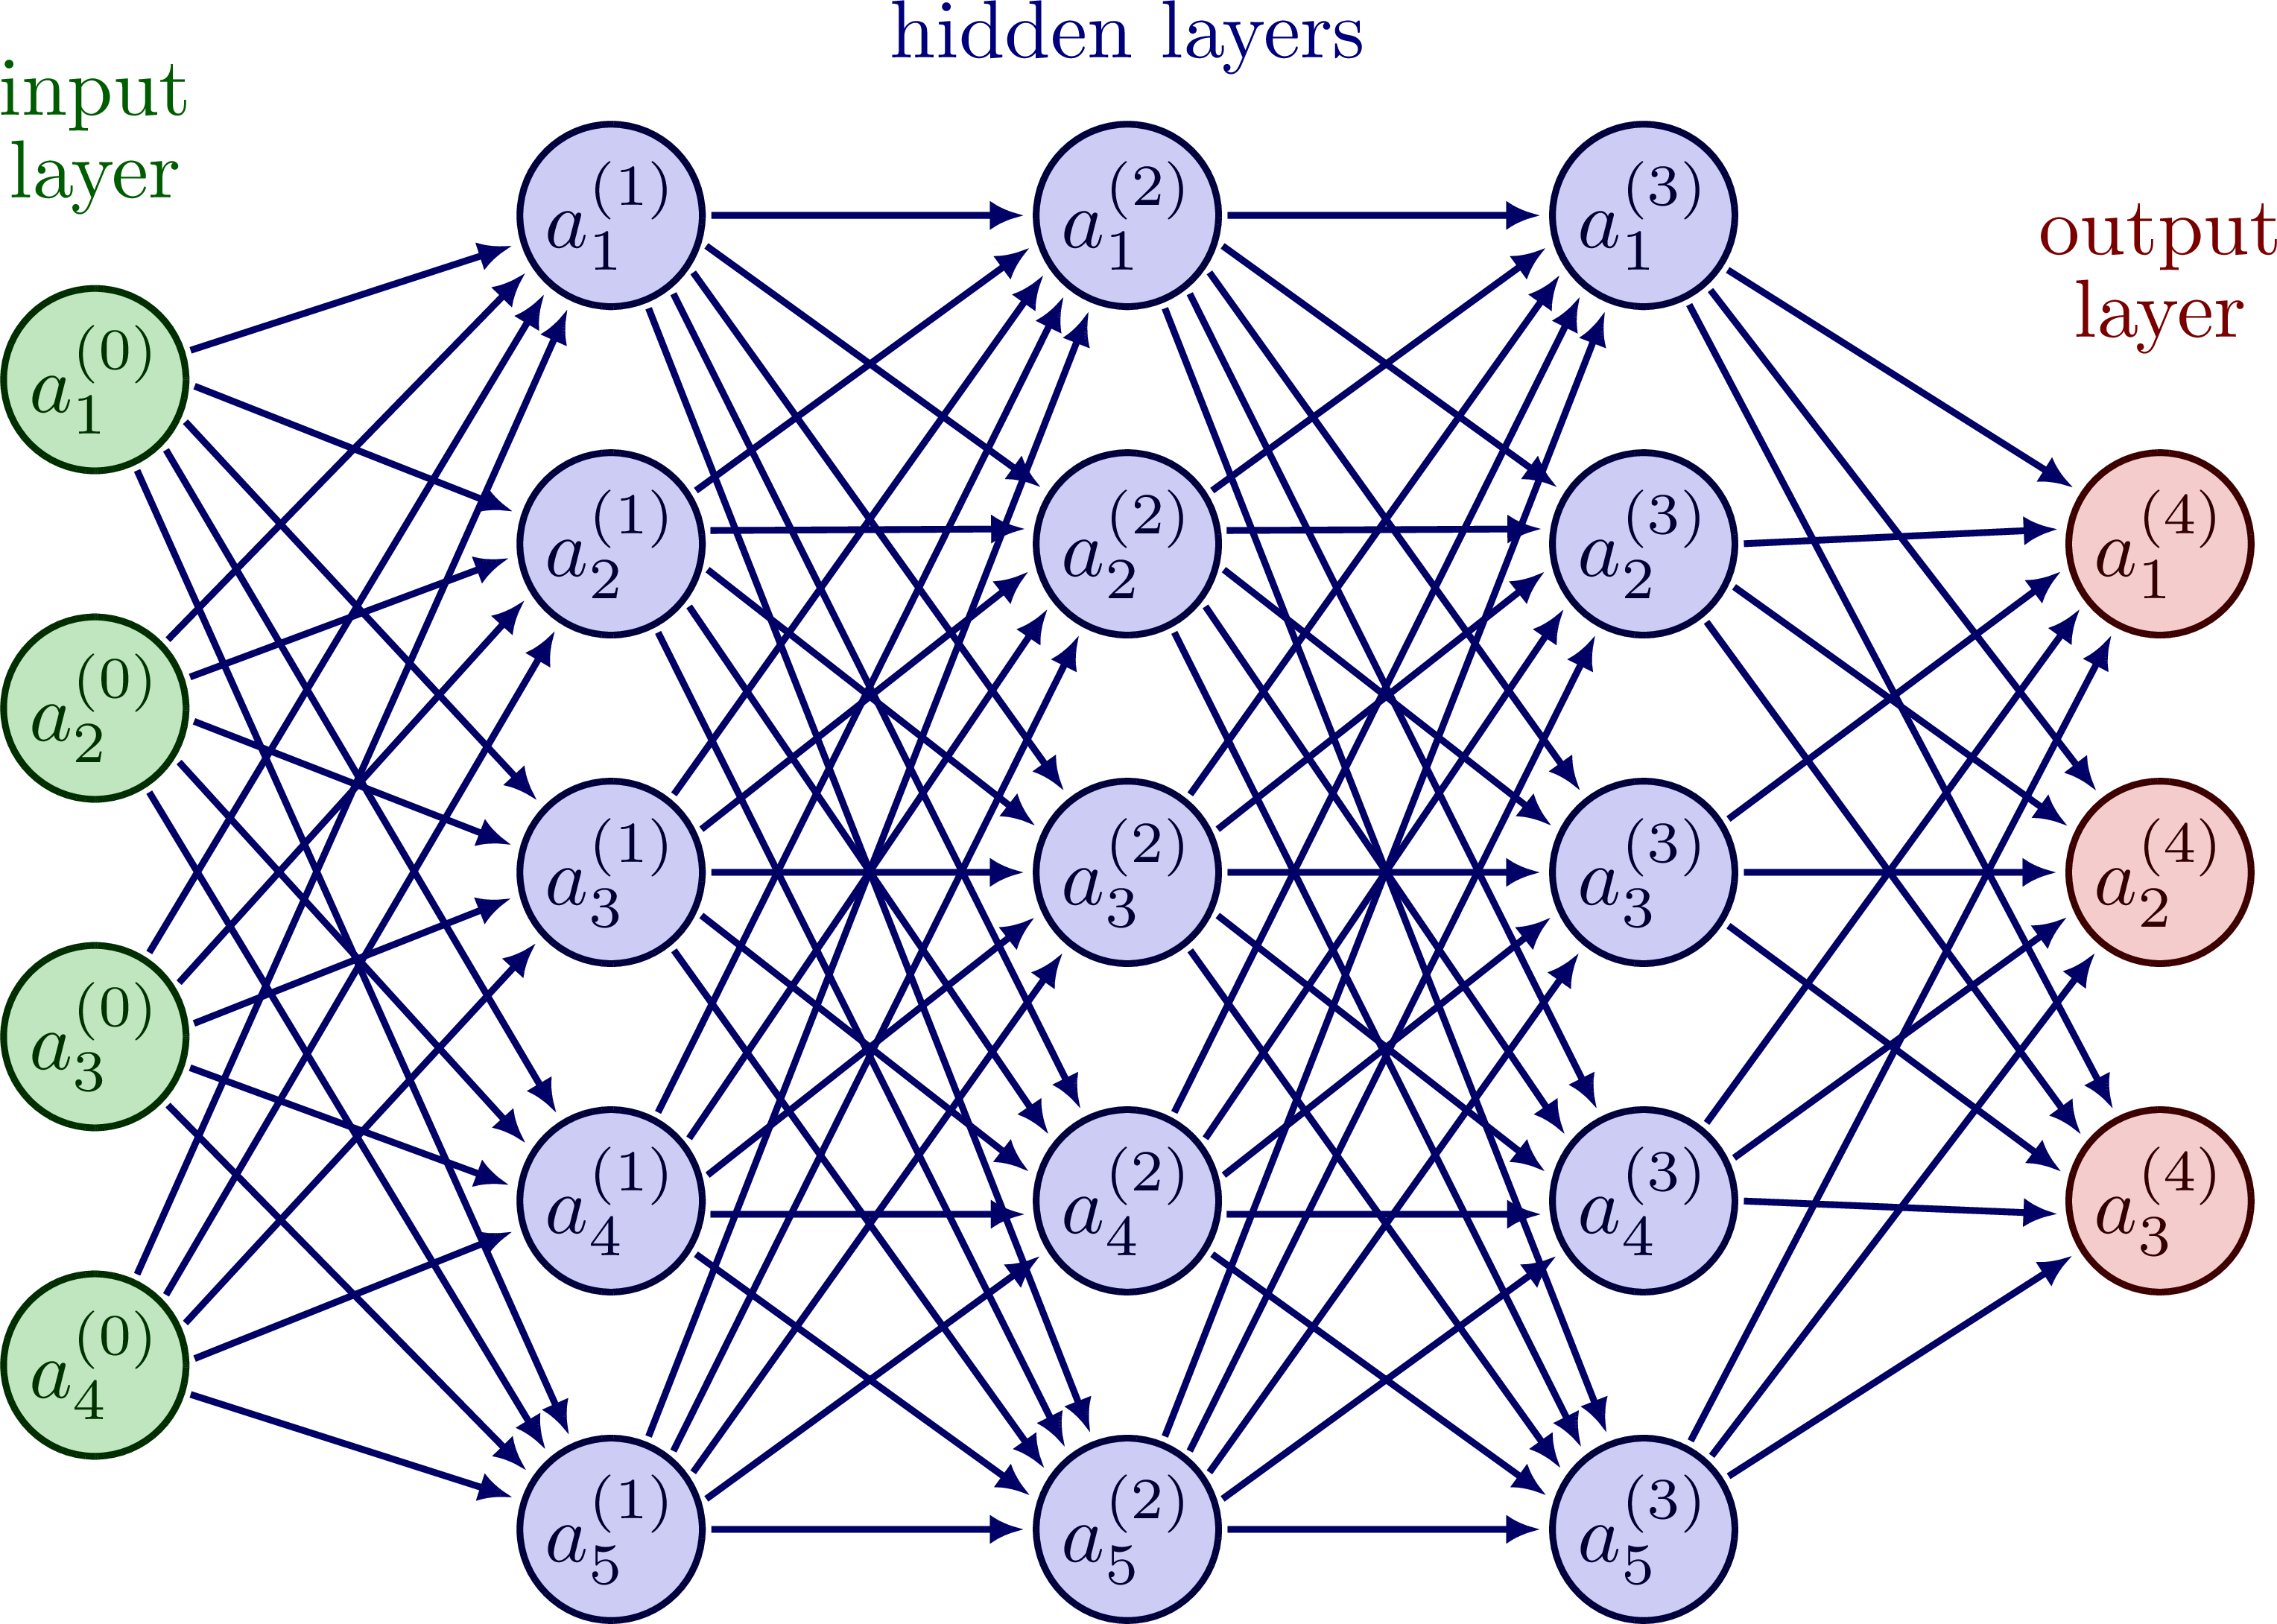

Let's create a simple NN to predict $\gamma = sin(x^2)$

**Disclaimer**

I am building a very simple NN for a toy problem.

Real world implementation is *A LOT* more complicated, you need to :

 understand the business/science application of your model, clean, plot, scale data, perform EDA, feature extractions, PCA, choose a model, choose an architecture, choose a loss function, hyperparamter selection and optimization, k fold cross validaton, train the model with accellerated GPUs, define useful KPIs, model global evaluation and performances, check for data drifting, integrate the model,....., you name it.


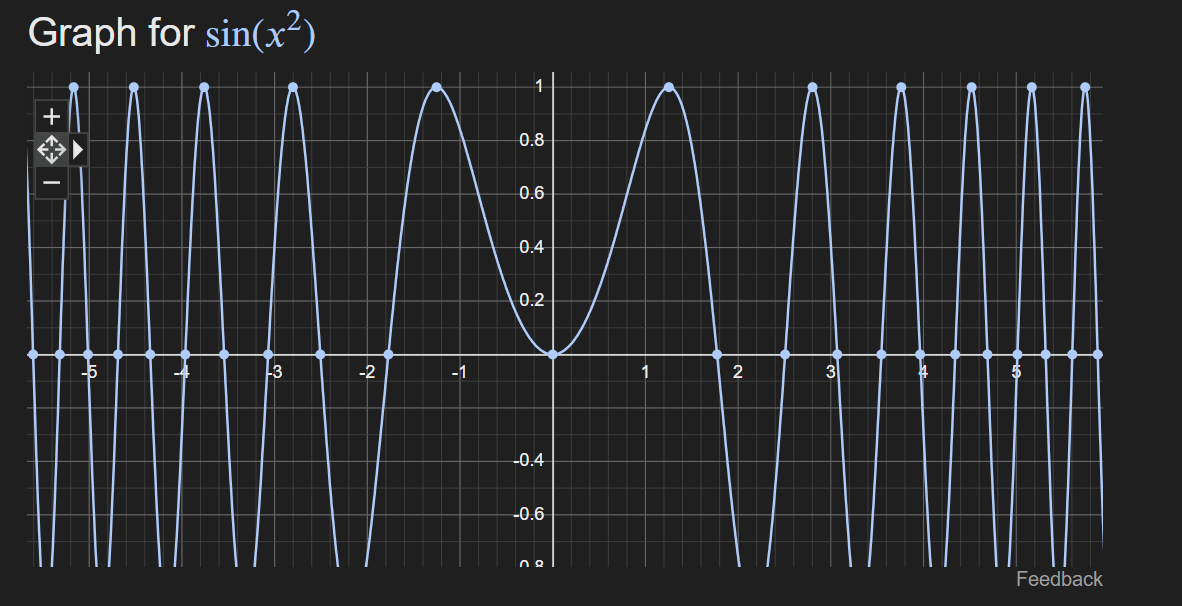

 As ∣x∣ gets larger, the function oscillates more and more rapidly. A simple linear model would fail completely here. A neural network, with its non-linear activation functions in the hidden layers, is perfect for approximating such complex relationships.

In [190]:
N = 5000
x_data = torch.linspace(-5,5,N)

# Neural network layers in PyTorch (like nn.Linear) expect 2D inputs of shape : (batch_size, num_features)
# without unsqueeze, pytorch thinks you have N features and one sample
x_data = x_data.unsqueeze(1)
tensor_information(x_data)

y_data = torch.sin(x_data ** 2 )
tensor_information(y_data)

Type :  <class 'torch.Tensor'>
Tensor shape :  (5000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 20072 bytes

Type :  <class 'torch.Tensor'>
Tensor shape :  (5000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 20072 bytes



In [191]:
# Shuffle the data to ensure the train and test sets are representative.
indices = torch.randperm(N)

N_tr = int ( N * 0.8 ) # 80/20 split ratio

x_train = x_data[indices[:N_tr]]
y_train = y_data[indices[:N_tr]]

tensor_information(x_train)
tensor_information(y_train)

Type :  <class 'torch.Tensor'>
Tensor shape :  (4000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 16072 bytes

Type :  <class 'torch.Tensor'>
Tensor shape :  (4000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 16072 bytes



In [192]:
x_test = x_data[indices[N_tr:]]
y_test = y_data[indices[N_tr:]]


tensor_information(x_test)
tensor_information(y_test)

Type :  <class 'torch.Tensor'>
Tensor shape :  (1000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 4072 bytes

Type :  <class 'torch.Tensor'>
Tensor shape :  (1000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 4072 bytes



In [193]:
print(f"Training set size: {len(x_train)} samples")
print(f"Test set size: {len(x_test)} samples")

Training set size: 4000 samples
Test set size: 1000 samples


In [194]:
class SequentialNN ( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential (
        nn.Linear(1,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,1)
            
        )
    
    def forward(self, x):
        return self.net(x)
            

Our NN should be a function like :
$$ F : \mathbb{R} \rightarrow \mathbb{R}^{\text{param}} \rightarrow \mathbb{R} $$

it takes a scalar as input, modify the input space to obtain generalization and then outputs a scalar.

Formally :
$$ \hat{y} = F(x ; \theta )$$

The network has a parameter space $\theta \in \mathbb{R}^{\text{param}}$ which are all the weights and biases of the network. The number of parameters is fixed once you define the architecture.

In [195]:
model = SequentialNN()
model

SequentialNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

One thing you might notice is that we never specify requires_grad=True for the model’s layers. Within a subclass of torch.nn.Module, it’s assumed that we want to track gradients on the layers’ weights for learning

In [196]:
print(type(model))

<class '__main__.SequentialNN'>


nn.Module (with a capital 'M') is a class defined within the torch.nn module. It's the base class for all neural network modules in PyTorch.

    So, when you write class SequentialNN(nn.Module):, you are defining a new class that inherits from the nn.Module class.

This is a fundamental concept in object-oriented programming called inheritance.

When SequentialNN inherits from nn.Module, it gains all the functionalities and attributes of nn.Module. Think of it as a blueprint that provides the essential machinery for any neural network component. By inheriting from it, your SequentialNN automatically gets:

Parameter Tracking: PyTorch knows to automatically find and manage all the nn.Parameter objects (like weights and biases)

forward() method: It sets the expectation that you will define a forward() method, which is how data will flow through your network.

Utility Methods: Access to methods like .to(), .train(), .eval(), .parameters(), .state_dict(), etc., which are crucial for training, evaluating, saving, and loading your model.

Automatic Differentiation Integration: It seamlessly integrates with PyTorch's autograd system, allowing for automatic gradient computation during backpropagation.


*What happens without nn.Module?*

    If you try to define a neural network without inheriting from nn.Module, you would lose a significant amount of built-in functionality and convenience.

In [197]:
params = list(model.parameters())
print(f"Before training : shape of params is ({len(params)}, {len(params[0])}) ")

before_train_norm_params = get_params_norm(model)
print(f"Before training paramter norm: {before_train_norm_params}")

Before training : shape of params is (8, 128) 
Before training paramter norm: 13.326847076416016


As you can see, even before training the model has initialized its parameters, if you want you can play with torch.manual_seed()

Let $x$ be the input to the neural network.

The neural network consists of many linear layers and many ReLU activation function.

This first layer transforms the input $x$ into a hidden representation $h_1$.
Let $W_1$ be the weight matrix and $b_1$ be the bias vector for the first linear layer.
Since the input has dimension 1 and the output has dimension 128, $W_1$ will be a $128 \times 1$ matrix and $b_1$ will be a $128 \times 1$ vector.
The operation for the first linear layer is:
$$ h_{1,i} = W_{1,i}x + b_{1,i} \quad \text{for }  $$
Or in vector form:
$$ \mathbf{h}_1 = W_1 x + \mathbf{b}_1 $$
where $\mathbf{h}_1$ is a $128 \times 1$ vector.


The Rectified Linear Unit (ReLU) activation function is applied element-wise to the output of the first linear layer.
$$ h_{2,i} = \text{ReLU}(h_{1,i}) = \max(0, h_{1,i}) \quad \text{for }  $$
Or in vector form:
$$ \mathbf{h}_2 = \text{ReLU}(\mathbf{h}_1) $$

The sequence repeat until the last output, a scalar, is computed

PyTorch records every operation that involves tensors with requires_grad=True:

Linear layer: computes x @ W.T + b

ReLU: computes max(0, z)

Linear layer again: computes h @ W2.T + b2

Each result is a non-leaf tensor with a grad_fn that points to how it was computed. PyTorch stores references to all inputs that have requires_grad=True so it can propagate gradients backward.

In [198]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
print(optimizer)
print(type(optimizer))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
<class 'torch.optim.adam.Adam'>


In [199]:
loss_fn = nn.MSELoss()
print(loss_fn)
print(type(loss_fn))

MSELoss()
<class 'torch.nn.modules.loss.MSELoss'>


    Let's create the training loop

In [200]:
epochs = 30000

train_loss = []
params_norm_list = []
grads_norm_list = []

for epoch in range(epochs):
    
    optimizer.zero_grad()             # Reset gradients to 0 to avoid gradient accumulation
    y_pred = model(x_train)           # Forward pass 
    loss = loss_fn(y_pred,y_train)    # compute MSE
    loss.backward()                   # Backprop
    
    grads_norm_list.append(get_grad_norm(model)) # Store gradient norm
    
    optimizer.step()                  # Update weights
    
    params_norm_list.append(get_params_norm(model)) # Store parameter norm
        
    train_loss.append(loss.item())    # Store loss

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.6f}")    

Epoch 0, Train Loss: 0.478827
Epoch 1000, Train Loss: 0.192267
Epoch 2000, Train Loss: 0.117475
Epoch 3000, Train Loss: 0.010766
Epoch 4000, Train Loss: 0.004627
Epoch 5000, Train Loss: 0.005914
Epoch 6000, Train Loss: 0.002416
Epoch 7000, Train Loss: 0.006860
Epoch 8000, Train Loss: 0.001534
Epoch 9000, Train Loss: 0.001078
Epoch 10000, Train Loss: 0.013541
Epoch 11000, Train Loss: 0.020463
Epoch 12000, Train Loss: 0.006098
Epoch 13000, Train Loss: 0.000633
Epoch 14000, Train Loss: 0.000230
Epoch 15000, Train Loss: 0.000782
Epoch 16000, Train Loss: 0.000280
Epoch 17000, Train Loss: 0.000987
Epoch 18000, Train Loss: 0.002366
Epoch 19000, Train Loss: 0.000185
Epoch 20000, Train Loss: 0.000113
Epoch 21000, Train Loss: 0.000070
Epoch 22000, Train Loss: 0.001259
Epoch 23000, Train Loss: 0.000673
Epoch 24000, Train Loss: 0.001714
Epoch 25000, Train Loss: 0.000235
Epoch 26000, Train Loss: 0.000115
Epoch 27000, Train Loss: 0.000056
Epoch 28000, Train Loss: 0.000753
Epoch 29000, Train Loss: 0.

**Warning:**  
When you call `.backward()` in PyTorch, the autograd engine accumulates gradients in the leaf nodes by default. If you do not clear the gradients before the next backward pass, the new gradients will be added to the existing ones, which can lead to incorrect gradient values. Always remember to reset gradients (e.g., using `optimizer.zero_grad()`) before each backward call.

    y_pred = model(x_train) (forward pass)

the first nn.Linear(1,128) maps (N_tr, 1) → (N_tr, 128).

ReLU keeps (N_tr, 128).

second nn.Linear(128,128) gives (N_tr, 128).

third nn.Linear(128,128) gives (N_tr, 128).

final nn.Linear(128,1) gives (N_tr, 1).

    loss.backward() (backward pass)
Because loss is scalar, calling backward() starts reverse-mode automatic differentiation from that scalar and propagates gradients back through the graph to every parameter that has requires_grad=True.

calling loss.backward() later will start reverse mode differentiation from this node without requiring an external gradient argument

During `loss.backward()`, PyTorch applies the chain rule to compute:

$$
\frac{\partial L}{\partial \theta}
$$

for every parameter $\theta$ in the network.

`optimizer.step()` updates each $\theta$ using its gradient. For SGD:

$$
\theta \leftarrow \theta - \eta \frac{\partial L}{\partial \theta}
$$

where $\eta$ is the learning rate.


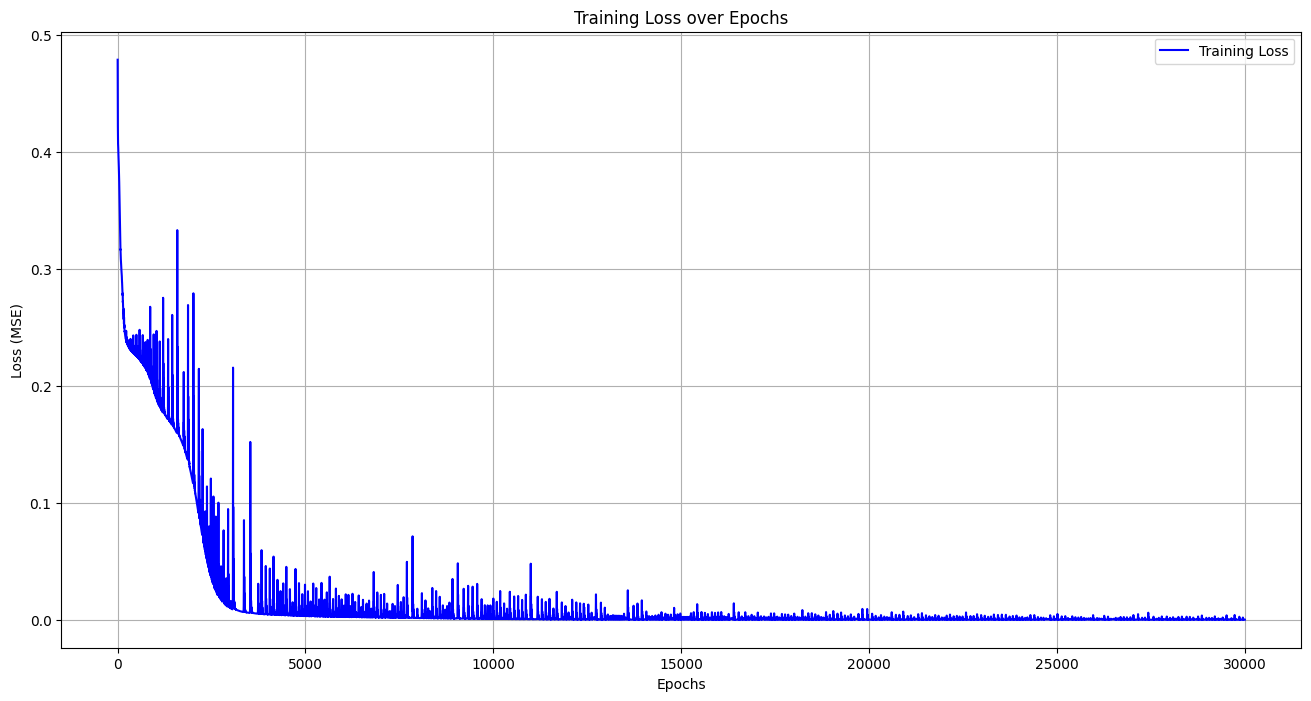

In [201]:
# Let's plot the training loss
plt.figure(figsize=(16, 8))
plt.plot(range(1, epochs + 1), train_loss, color='blue', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

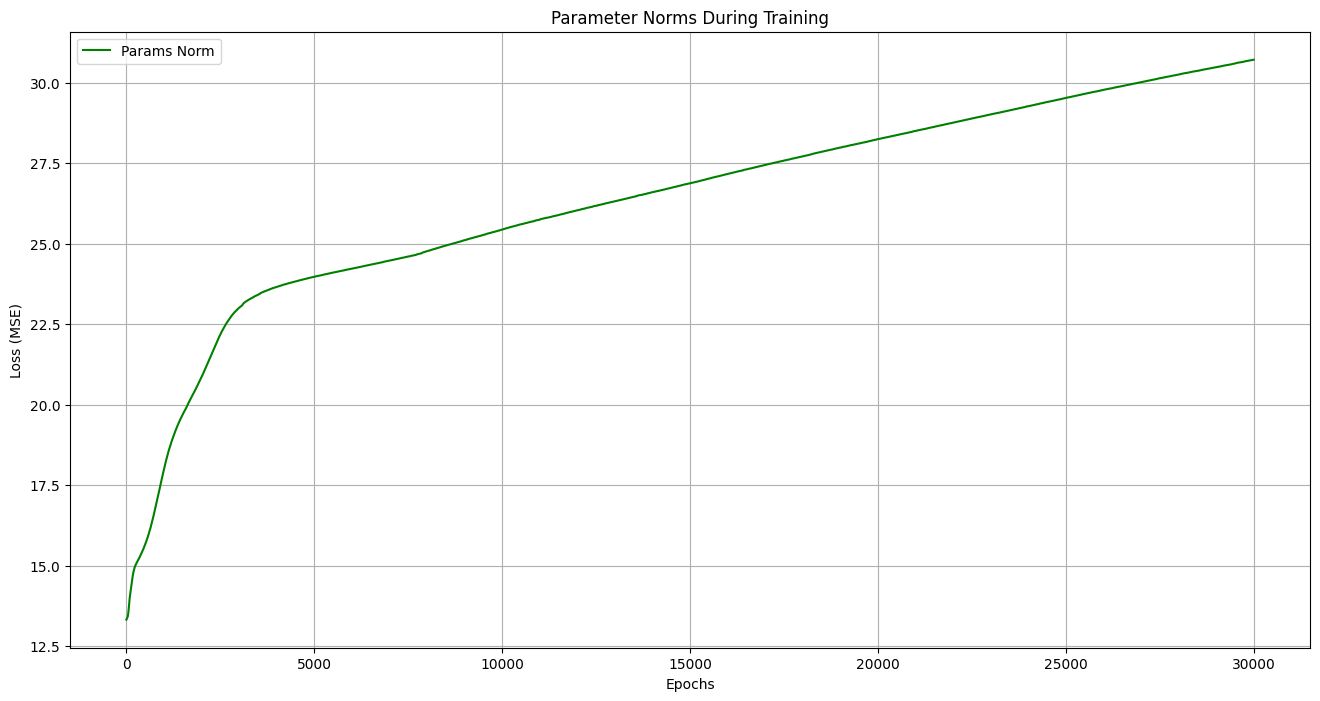

In [202]:
# Let's plot params norm
plt.figure(figsize=(16, 8))
plt.plot(params_norm_list, color = "green", label="Params Norm")
plt.title("Parameter Norms During Training")
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Due to the absence of any regularization ( like L2 penalty ), paramters norm tends to increase to better represent data.

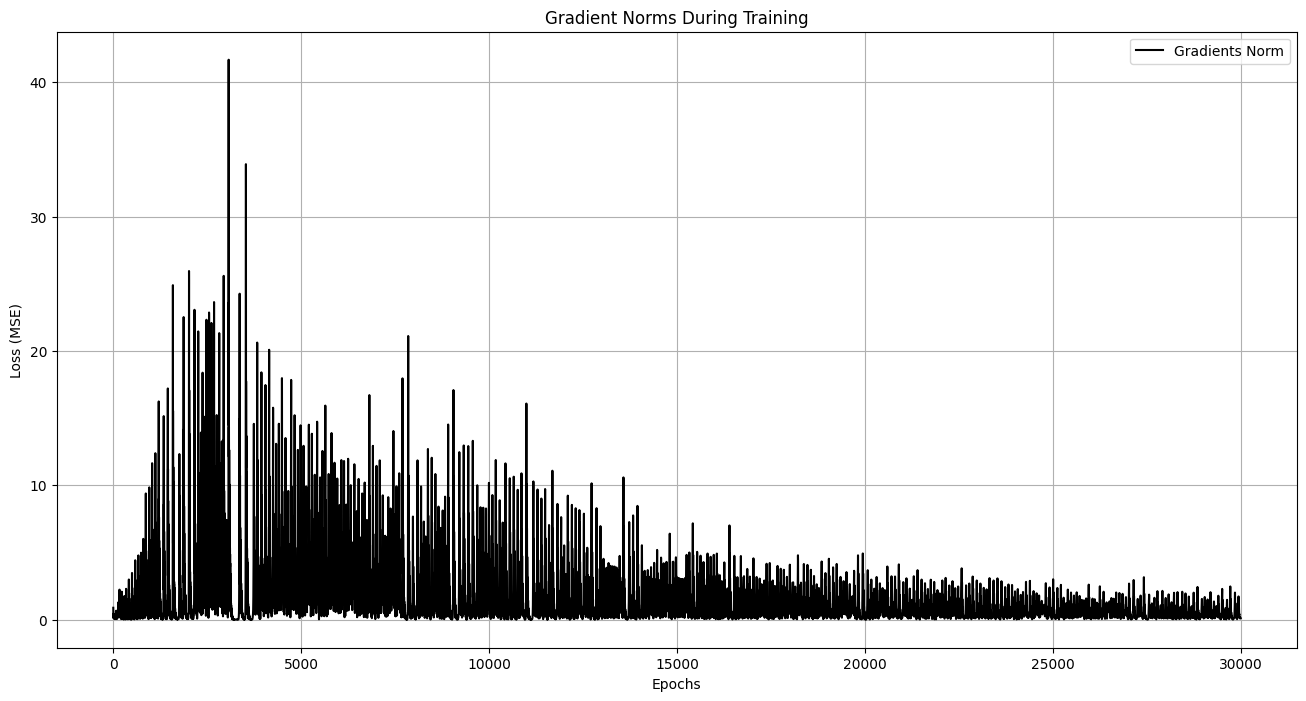

In [203]:
# Let's plot gradient norm
plt.figure(figsize=(16, 8))
plt.plot(grads_norm_list, color = "black", label="Gradients Norm")
plt.title("Gradient Norms During Training")
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [204]:
# Switch to evaluation mode and disable gradients
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    test_loss = loss_fn(y_test_pred, y_test)

when we use a model for inference, it is a best practice to use the torch.no_grad() to tell PyTorch that it doesn’t need to keep track of the gradients, which can result in significant savings in memory and computation.

In [205]:
tensor_information(y_test_pred)
print(f"Test loss is {test_loss}")

Type :  <class 'torch.Tensor'>
Tensor shape :  (1000, 1)
Device :  cpu
Approximate total size (metadata + data buffer): 4072 bytes

Test loss is 5.9934794990113005e-05


the test loss is very low --> NICE :)

In [206]:
# Convert tensors to numpy for nice plotting
x_test_np = x_test.numpy()
y_test_np = y_test.numpy()
y_pred_np = y_test_pred.numpy()

# Sort x for a smooth line plot
# Then you sort the data by the x-values. 
# This is important because the test set was shuffled, so if you just plot them directly, the line would jump all over the place.

sorted_indices = x_test_np[:,0].argsort() # argsort is a function such that x[x.argosort()] is a sorted in ascending order
x_sorted = x_test_np[sorted_indices]
y_sorted = y_test_np[sorted_indices]
y_pred_sorted = y_pred_np[sorted_indices]



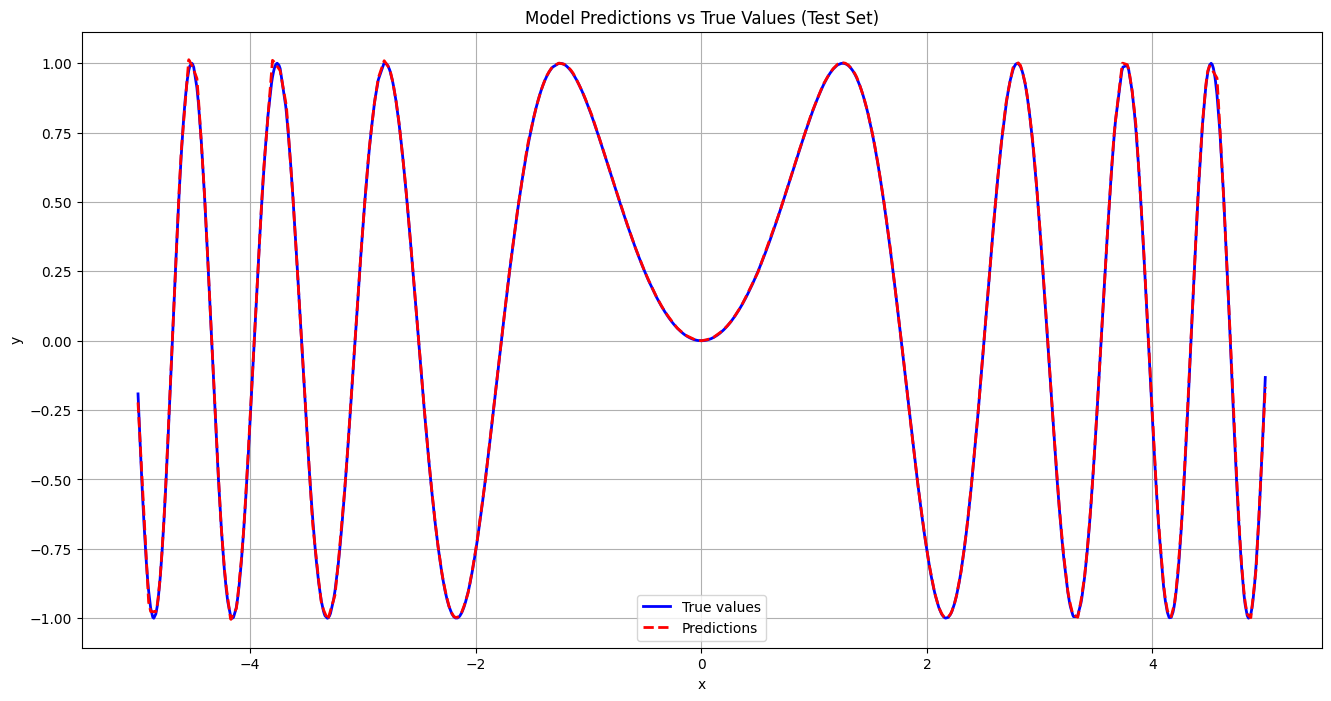

In [207]:
# plot test data
plt.figure(figsize=(16,8))
plt.plot(x_sorted, y_sorted, color='blue', linewidth=2, label="True values")
plt.plot(x_sorted, y_pred_sorted, color='red', linestyle='--', linewidth=2, label="Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model Predictions vs True Values (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

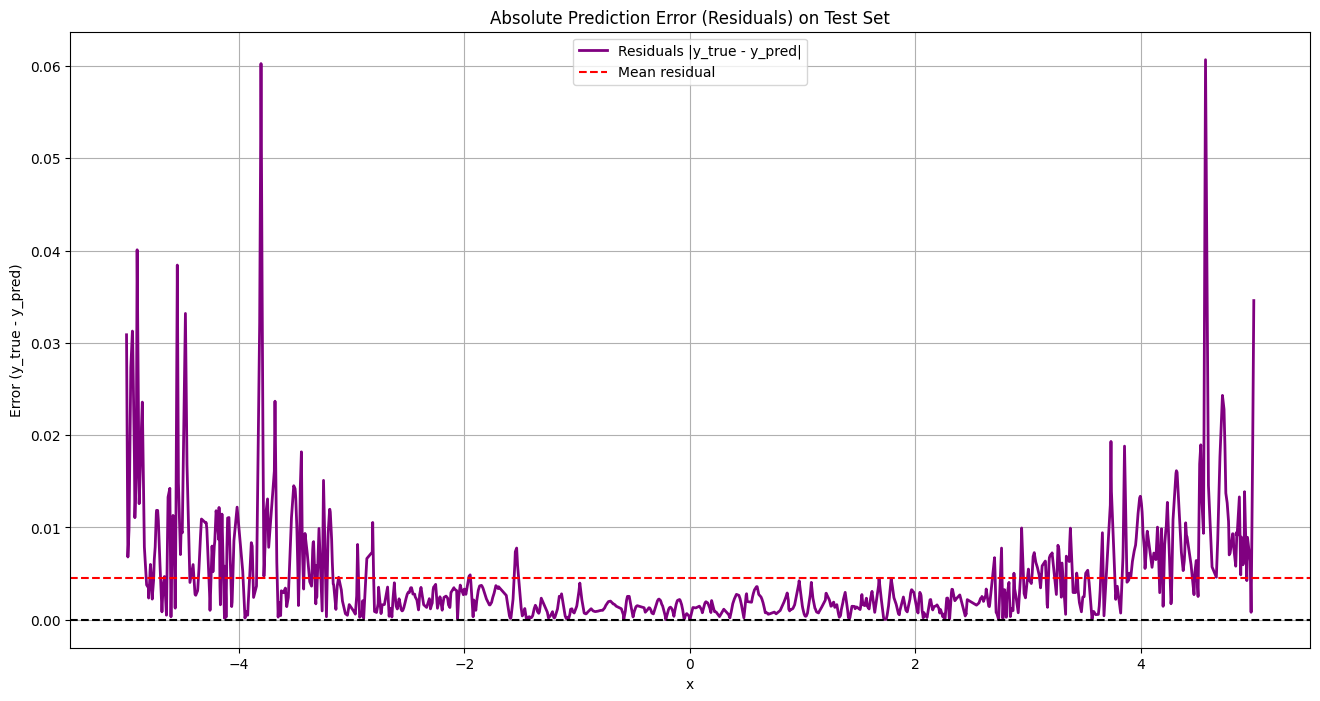

In [208]:
# Residuals
residuals = np.abs(y_test_np - y_pred_np)

# Sort residuals with the same indices (to keep the x order)
residuals_sorted = residuals[sorted_indices]

plt.figure(figsize=(16,8))
plt.plot(x_sorted, residuals_sorted, color='purple', linewidth=2, label="Residuals |y_true - y_pred|")
plt.axhline(residuals_sorted.mean(), color='red', linestyle='--', label="Mean residual") 
plt.axhline(0, color='black', linestyle='--')  # reference line
plt.xlabel("x")
plt.ylabel("Error (y_true - y_pred)")
plt.title("Absolute Prediction Error (Residuals) on Test Set")
plt.grid(True)
plt.legend()
plt.show()